In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from KANConv import KAN_Convolutional_Layer

# Global variables
global device, print_freq
print_freq = 300
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

WORKING_PATH = 'KAN_avgprop/'
os.makedirs(WORKING_PATH, exist_ok=True)

# Dataset class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, inp, props, out):
        self.inp = inp
        self.props = props
        self.out = out

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.props[index], self.out[index]

# AverageMeter class
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## KanConv only

In [2]:
# RVEKAN Model
class RVEKAN(torch.nn.Module):
    def __init__(self):
        super(RVEKAN, self).__init__()
        self.conv1 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), device=device)
        self.conv2 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), device=device)
        self.fc1 = torch.nn.Linear(260, 256)
        self.fc2 = torch.nn.Linear(256, 3)
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = torch.nn.Dropout(p=0.7)

    def forward(self, x, props):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = torch.cat((props, x), 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

# Training function
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, props, output) in enumerate(train_loader):
            input_, props, output = input_.to(device), props.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_, props)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, props, output) in enumerate(test_loader):
                input_, props, output = input_.to(device), props.to(device), output.to(device)
                outputs = model(input_, props)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss_KANavgprop' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss_KANavgprop' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

def main_program(inp, props, out, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :, :]
    out_train = out[0:num_sample]
    props_train = props[0:num_sample]
    training_set = MyDataset(inp_train, props_train, out_train)

    inp_test = inp[num_sample:inp.shape[0], :, :, :]
    out_test = out[num_sample:inp.shape[0]]
    props_test = props[num_sample:inp.shape[0]]
    test_set = MyDataset(inp_test, props_test, out_test)

    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = RVEKAN().to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), WORKING_PATH + model_name)

    return model

(4000, 3)
(4000, 128, 128)
(4000, 4)
model name: model_3200train_150ep_KAN
cuda
model_3200train_150ep_KAN
RVEKAN(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (fc1): Linear(in_features=260, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.363056, Avg Batch Time: 1.067, Avg Data Time: 0.013
Epoch [2/150], Batch [0/13], Loss: 0.321506, Avg Batch Time: 0.917, Avg Data Time: 0.012
Epo

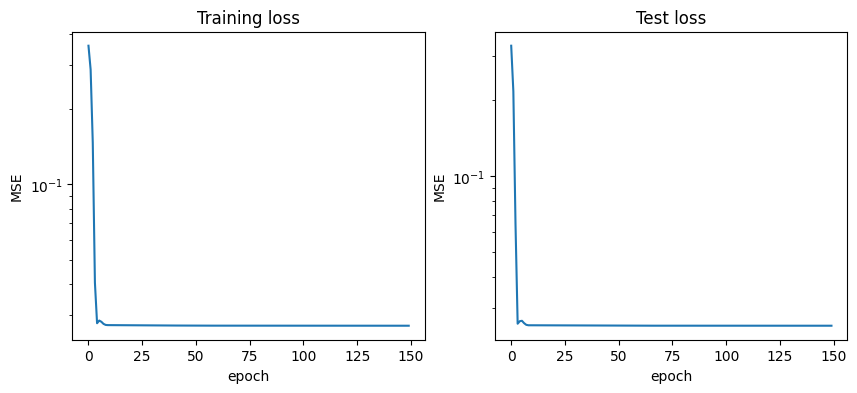

In [3]:
# Main script
if __name__ == "__main__":
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')
    mat_props = np.load(file='data/cnn_mat_props_part2.npy')

    ## calculate averaged mat_props and reshape 4*1 avg values into a new 4000*4 mat_props array
    means = np.mean(mat_props, axis=0)
    mat_props = np.tile(means, (4000, 1))
    
    # normalize mat_props
    props_scaler = MinMaxScaler()
    mat_props = props_scaler.fit_transform(mat_props)
    joblib.dump(props_scaler, WORKING_PATH + 'props_scaler.pkl')
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)
    print(mat_props.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    mat_props_tensor = torch.from_numpy(mat_props).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'KAN'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    KAN_avgprop_model = main_program(rve_tensor, mat_props_tensor, stiffness_tensor, trainer_info, model_name)

## KanConv+KanLinear

In [4]:
# RVEKAN Model
from KANLinear import KANLinear
class RVEKAN(torch.nn.Module):
    def __init__(self):
        super(RVEKAN, self).__init__()
        self.conv1 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), device=device)
        self.conv2 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), device=device)
        self.fc1 = KANLinear(260,256)
        self.fc2 = KANLinear(256,3)
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = torch.nn.Dropout(p=0.7)

    def forward(self, x, props):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = torch.cat((props, x), 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

# Training function
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, props, output) in enumerate(train_loader):
            input_, props, output = input_.to(device), props.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_, props)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, props, output) in enumerate(test_loader):
                input_, props, output = input_.to(device), props.to(device), output.to(device)
                outputs = model(input_, props)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss_KKANavgprop' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss_KKANavgprop' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

def main_program(inp, props, out, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :, :]
    out_train = out[0:num_sample]
    props_train = props[0:num_sample]
    training_set = MyDataset(inp_train, props_train, out_train)

    inp_test = inp[num_sample:inp.shape[0], :, :, :]
    out_test = out[num_sample:inp.shape[0]]
    props_test = props[num_sample:inp.shape[0]]
    test_set = MyDataset(inp_test, props_test, out_test)

    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = RVEKAN().to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), WORKING_PATH + model_name)

    return model

(4000, 3)
(4000, 128, 128)
(4000, 4)
model name: model_3200train_150ep_KAN
cuda
model_3200train_150ep_KAN
RVEKAN(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (fc1): KANLinear(
    (base_activation): SiLU()
  )
  (fc2): KANLinear(
    (base_activation): SiLU()
  )
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.373405, Avg Batch Time: 0.814, Avg Data Time: 0.011
Epoch [2/150], Batch [0/13], Loss: 0.273401, Avg Batch Time: 0.804, Avg Data Time: 0.009
Epoch [3/150], Ba

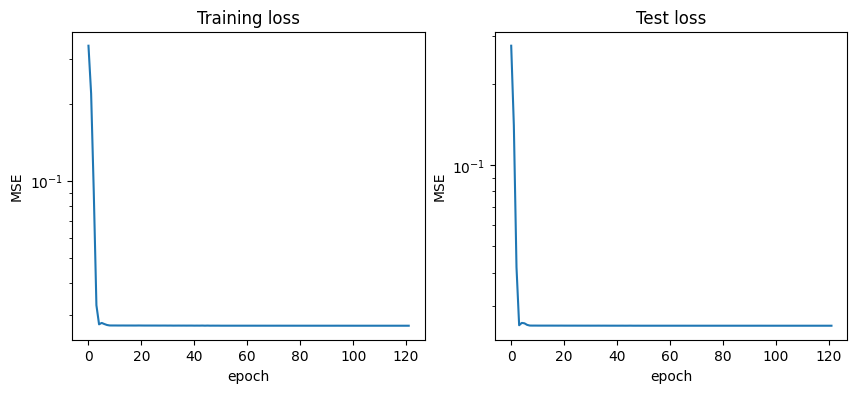

In [5]:
# Main script
if __name__ == "__main__":
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')
    mat_props = np.load(file='data/cnn_mat_props_part2.npy')

    ## calculate averaged mat_props and reshape 4*1 avg values into a new 4000*4 mat_props array
    means = np.mean(mat_props, axis=0)
    mat_props = np.tile(means, (4000, 1))
    
    # normalize mat_props
    props_scaler = MinMaxScaler()
    mat_props = props_scaler.fit_transform(mat_props)
    joblib.dump(props_scaler, WORKING_PATH + 'props_scaler.pkl')
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)
    print(mat_props.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    mat_props_tensor = torch.from_numpy(mat_props).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'KAN'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    KKAN_avgprop_model = main_program(rve_tensor, mat_props_tensor, stiffness_tensor, trainer_info, model_name)

## Kconv with graduall lr decrease

In [12]:
# RVEKAN Model
class RVEKAN(torch.nn.Module):
    def __init__(self):
        super(RVEKAN, self).__init__()
        self.conv1 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), device=device)
        self.conv2 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), device=device)
        self.fc1 = torch.nn.Linear(260, 256)
        self.fc2 = torch.nn.Linear(256, 3)
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = torch.nn.Dropout(p=0.15)

    def forward(self, x, props):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = torch.cat((props, x), 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

# Training function
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, props, output) in enumerate(train_loader):
            input_, props, output = input_.to(device), props.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_, props)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, props, output) in enumerate(test_loader):
                input_, props, output = input_.to(device), props.to(device), output.to(device)
                outputs = model(input_, props)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss_KANavgprop' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss_KANavgprop' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

def main_program(inp, props, out, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :, :]
    out_train = out[0:num_sample]
    props_train = props[0:num_sample]
    training_set = MyDataset(inp_train, props_train, out_train)

    inp_test = inp[num_sample:inp.shape[0], :, :, :]
    out_test = out[num_sample:inp.shape[0]]
    props_test = props[num_sample:inp.shape[0]]
    test_set = MyDataset(inp_test, props_test, out_test)

    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = RVEKAN().to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), WORKING_PATH + model_name)

    return model

(4000, 3)
(4000, 128, 128)
(4000, 4)
model name: model_3200train_150ep_KAN
cuda
model_3200train_150ep_KAN
RVEKAN(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (fc1): KANLinear(
    (base_activation): SiLU()
  )
  (fc2): KANLinear(
    (base_activation): SiLU()
  )
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.378630, Avg Batch Time: 1.079, Avg Data Time: 0.027
Epoch [2/150], Batch [0/13], Loss: 0.285290, Avg Batch Time: 0.911, Avg Data Time: 0.010
Epoch [3/150], Ba

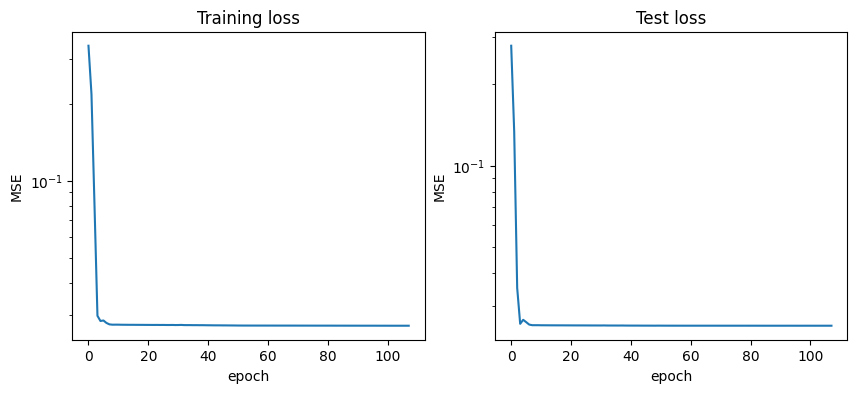

In [6]:
# Main script
if __name__ == "__main__":
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')
    mat_props = np.load(file='data/cnn_mat_props_part2.npy')

    ## calculate averaged mat_props and reshape 4*1 avg values into a new 4000*4 mat_props array
    means = np.mean(mat_props, axis=0)
    mat_props = np.tile(means, (4000, 1))
    
    # normalize mat_props
    props_scaler = MinMaxScaler()
    mat_props = props_scaler.fit_transform(mat_props)
    joblib.dump(props_scaler, WORKING_PATH + 'props_scaler.pkl')
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)
    print(mat_props.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    mat_props_tensor = torch.from_numpy(mat_props).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'KAN'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    KANmodel = main_program(rve_tensor, mat_props_tensor, stiffness_tensor, trainer_info, model_name)

In [7]:
import time
import copy
import pandas as pd
import glob

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

KAN_avgprop_num_params = count_parameters(KAN_avgprop_model)
KKAN_avgprop_num_params = count_parameters(KKAN_avgprop_model)

print("The number of parameters in KAN_avgprop:", KAN_avgprop_num_params)
print("The number of parameters in KKAN_avgprop:", KKAN_avgprop_num_params)

The number of parameters in KAN_avgprop: 67767
The number of parameters in KKAN_avgprop: 673460


C:\Users\Aidy\AppData\Local\Temp\ipykernel_7352\13312945.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
